In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.filterwarnings('ignore')

%matplotlib inline

In [78]:
data = pd.read_csv('kc_house_data.csv')

In [76]:
og_data = pd.read_csv('kc_house_data.csv')

In [86]:
def price_scatters(rws, cls, col_list):
    fig, axes = plt.subplots(nrows=rws, ncols=cls, figsize=(16,3))

    for xcol, ax in zip(col_list, axes):
        data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.2, color='#ff00ff', s=2)

In [87]:
norm_hsize = (15,4)

def histograms(n_rows, n_cols, variables, bin_num, size):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        data[var_name].hist(bins=bin_num,figsize=size,ax=ax)
        ax.set_title(var_name+" Distribution")
    plt.show()

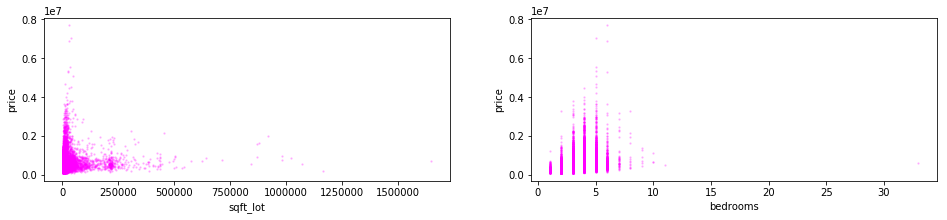

In [88]:
price_scatters(1, 2, ['sqft_lot', 'bedrooms'])

# Data Exploration and the first round of column cuts

This is me coming back and dropping the columns I won't need. There will be further cuts, but once I get the information I need from . Most of these columns I feel like I could find something useful for, but ultimately I have a limited amount of time here.

This is after the fact I'm coming back and removing columns I'm not using to speed up processing time, which is why these coumns are being dropped here. The zipcodes had some useful information, but overall it wasn;t enough for me to feel it was helpful.

The same with the lat/long. I would have liked to determine nearest neighbors to waterfront properties and create more features, but the dealine loomed.

I found floors didn't assist as much as some of the new features, so it was also dropped.

In [6]:
data = data.drop(['id', 'floors', 'lat', 'long', 'zipcode'], axis=1)

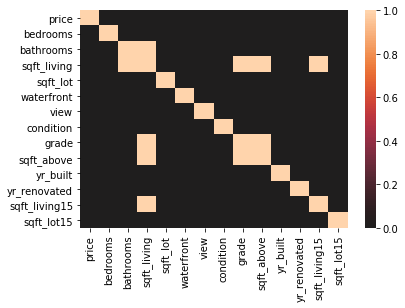

In [7]:
sns.heatmap(abs(data.corr()) > 0.75, center=0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10560d240>,
      dtype=object)

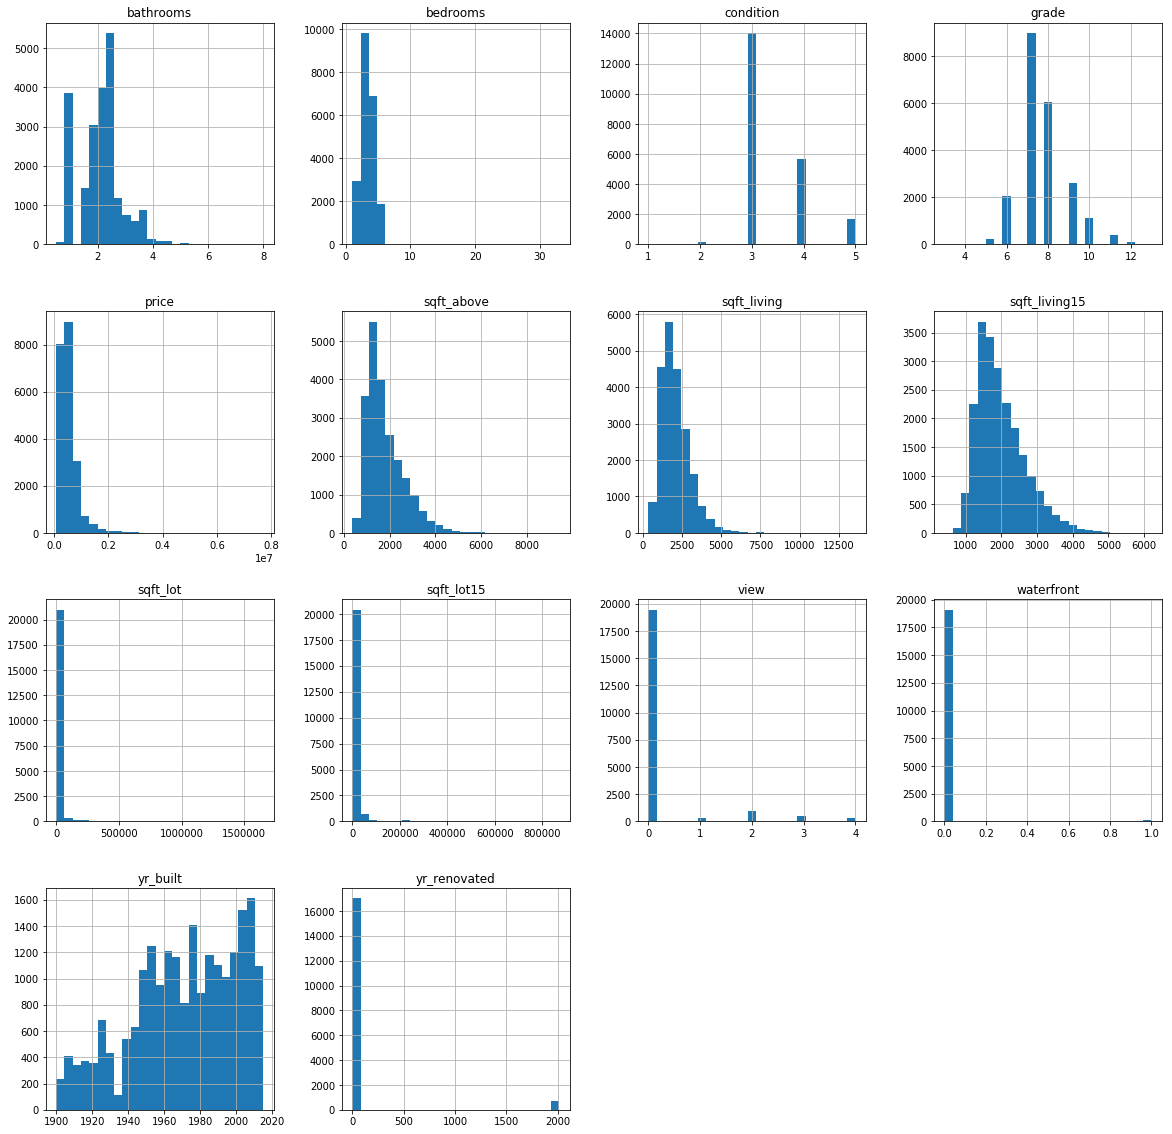

In [8]:
data.hist(figsize = (20,20), bins = 25)

# The binary (or nearly binary) features

Not all the features are actually binary, but I approached many of them as if they were based on the data.

* waterfront
* year renovated
* view

# Removing Outliers
Okay, so there are some outliers that need to be removed before we can start making real moves and getting a better understanding of the histograms and scatterplots. Bedrooms, bathrooms, sqft_living and sqft_lot jump out to me. Looking at their scatter graphs:

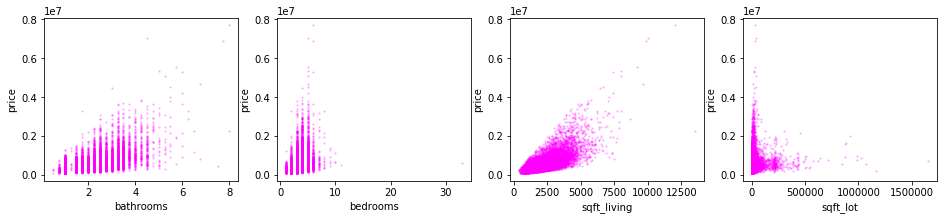

In [9]:
price_scatters(1, 4, ['bathrooms', 'bedrooms', 'sqft_living', 'sqft_lot'])

In [10]:
# oh, what's up insane bedroom number? You are obivously user error. Let's get rid of you.
data = data[data.bedrooms < 10]

#ridding ouselves of the outliers in bathrooms.
# I don't believe that anyhting below a three quarter bath is not a mistake
# and I want to get rid of some of the max data.
data = data[data['bathrooms'] < 7.5]
data = data[data['bathrooms'] >= 0.5]

# I'm using the .999 quantile to remove the  outliers on the high and low end of the lot and square footage
data= data[data['sqft_lot'] < data.sqft_lot.quantile(.999)]
data= data[data['sqft_lot'] > data.sqft_lot.quantile(.001)]

data = data[data['sqft_living'] < data.sqft_living.quantile(.999)]
data = data[data['sqft_living'] > data.sqft_living.quantile(.001)]

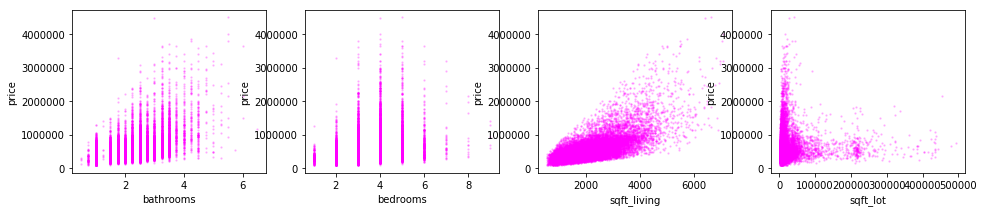

In [11]:
# Let's see the difference!

price_scatters(1, 4, ['bathrooms', 'bedrooms', 'sqft_living', 'sqft_lot'])

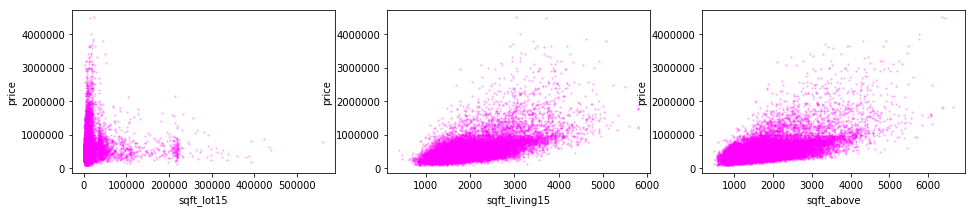

In [12]:
price_scatters(1, 3, ['sqft_lot15', 'sqft_living15',  'sqft_above'])

In [13]:
# If I'm gonna cut the neighbors, I've gotta cut the nearby lots
data = data[data.sqft_lot15 < data.sqft_lot.quantile(.998)]
data = data[data.sqft_lot15 > data.sqft_lot.quantile(.001)]

#ridding ouselves of the outliers in bathrooms.
# I don't believe that anyhting below a three quarter bath is not a mistake
# and I want to get rid of some of the max data.
data = data[data.sqft_living15 < data.sqft_living15.quantile(.998)]
data = data[data.sqft_living15 > data.sqft_living15.quantile(.001)]


# I'm using the .999 quantile to remove the  outliers on the high and low end of the lot and square footage.
# The graph looks a lit like Long Island. I grew up somewhere around 3000 sqft_above and $1000000
data = data[data.sqft_above < data.sqft_above.quantile(.998)]
data = data[data.sqft_above > data.sqft_above.quantile(.001)]

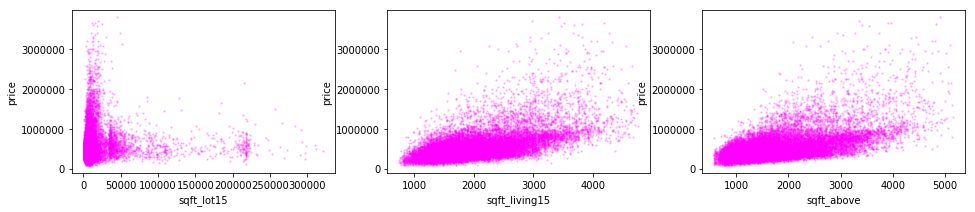

In [14]:
price_scatters(1, 3, ['sqft_lot15', 'sqft_living15',  'sqft_above'])

# What about price?

Yeah, we're trying to predict price, but I'm going back and inserting this late in my research to think about removing outliers because I never touched it.

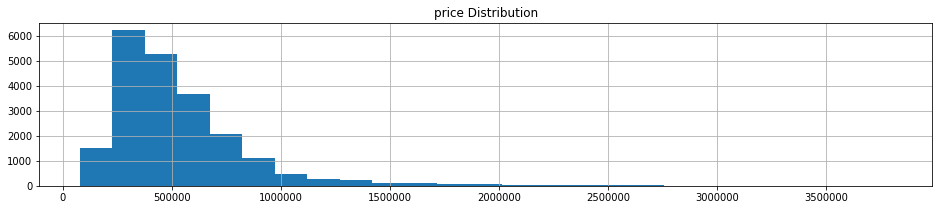

In [15]:
histograms(1, 1, ['price'], 25, (16,3))

That's not exactly the kinda graph I'm hoping to see. There *has* to be something on the high end that's clumping everything on the left.

In [16]:
#Yo, there is an extra zero in play between 75% and max.
data.price.describe()

count    2.134600e+04
mean     5.324772e+05
std      3.345119e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.400000e+05
max      3.800000e+06
Name: price, dtype: float64

In [17]:
(data[data['price'] > data.price.quantile(.999)].price.mean()) / (data['price'].mean())

6.3357389998284495

Checking on the mean of the top 0.001%, which ends up being 6.8x the price mean.

Let's remove the top and bottom 0.001% from price and see what it does.

In [18]:
data = data[data['price'] < data.price.quantile(.999)]
data = data[data['price'] > data.price.quantile(.001)]

In [19]:
# It doesn't do too much, but it does reduce the difference by 12%,
# which means the highest of highs were skewed more than the lowest of lows
(data[data['price'] > data.price.quantile(.999)].price.mean()) / (data['price'].mean())

5.553513028058019

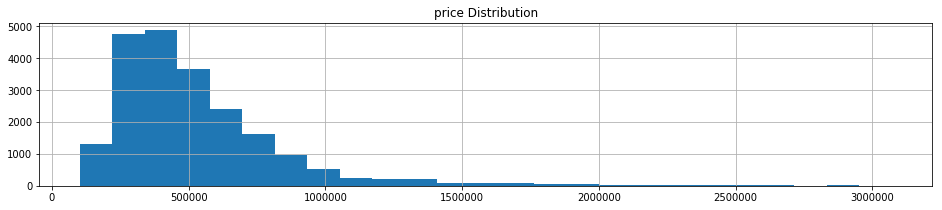

In [20]:
histograms(1, 1, ['price'], 25, (16,3))

Let's check back in with our histogram for the non binary values.

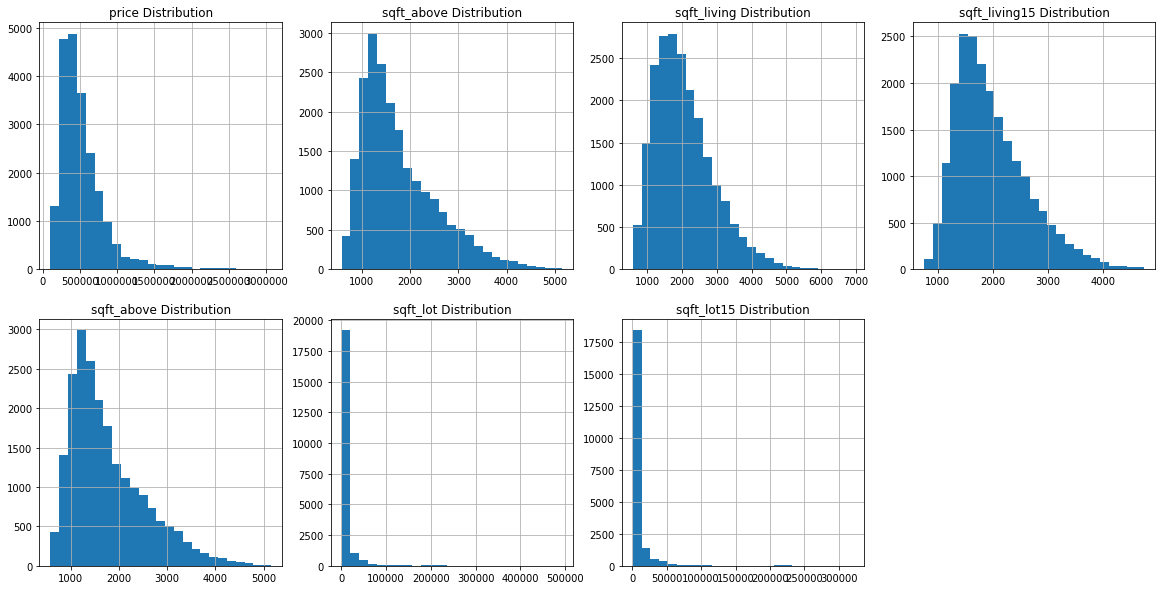

In [21]:
histograms(2, 4, ['price', 'sqft_above', 'sqft_living', 'sqft_living15', 'sqft_above', 'sqft_lot', 'sqft_lot15'], 25, (20,10))

# New Columns, New Me

I'm using my real world experience here to add a few stats that mattered to me when purchasing my apartment.
Price per usable square foot (above ground), bedrooms per bathroom, and size comparisons between nearest 15 and the home. What's the usable space, what's the bedroom to bathroom situation like, and let's keep up with the Jonses. Let's take a look at our new stats after we make them.

In [22]:
data['price_per_sqft'] = data['price'] / data['sqft_above']
data['bpb'] = data['bedrooms'] / data['bathrooms']
data['comp15_sqft_living'] = data['sqft_living'] / data['sqft_living15']
data['comp15_sqft_lot'] = data['sqft_lot'] / data['sqft_lot15']

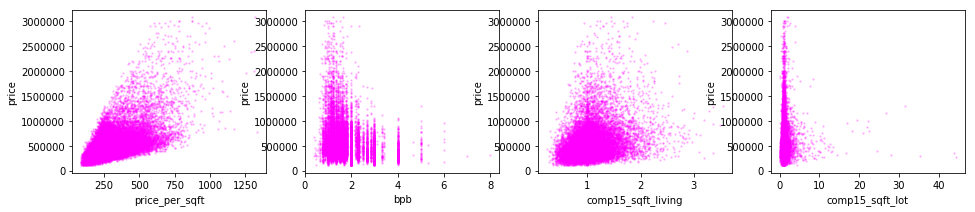

In [23]:
new_cols = ['price_per_sqft', 'bpb', 'comp15_sqft_living', 'comp15_sqft_lot']
price_scatters(1, 4, new_cols)

In [24]:
data = data[data['comp15_sqft_lot'] < 15]
data = data[data['comp15_sqft_living'] < 4]
data = data[data['bpb'] < 6]
data = data[data['price_per_sqft'] < 1250]

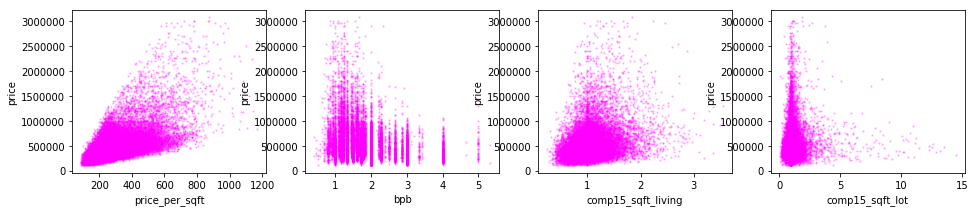

In [25]:
price_scatters(1, 4, new_cols)

# Check for Null Values
There's a few, but no huge amounts. In all cases, I'm treating them like Boolean values, so these are as good as 0 to me. I'd rather fill these values than remove the rows.

In [26]:
data.isnull().sum()

date                     0
price                    0
bedrooms                 0
bathrooms                0
sqft_living              0
sqft_lot                 0
waterfront            2343
view                    62
condition                0
grade                    0
sqft_above               0
sqft_basement            0
yr_built                 0
yr_renovated          3776
sqft_living15            0
sqft_lot15               0
price_per_sqft           0
bpb                      0
comp15_sqft_living       0
comp15_sqft_lot          0
dtype: int64

In [27]:
# fill in null values
data['yr_renovated'].fillna(0, inplace = True)
data['waterfront'].fillna(0, inplace = True)
data['view'].fillna(0, inplace = True)

# Using the mode to fill in null values

I used the mode because I'm basically viewing the data as boolean. You were renovated or you weren't. You have a view or you don't. You're by the water or you're not. The histograms show the story here.

In [28]:
data.isnull().sum()

date                  0
price                 0
bedrooms              0
bathrooms             0
sqft_living           0
sqft_lot              0
waterfront            0
view                  0
condition             0
grade                 0
sqft_above            0
sqft_basement         0
yr_built              0
yr_renovated          0
sqft_living15         0
sqft_lot15            0
price_per_sqft        0
bpb                   0
comp15_sqft_living    0
comp15_sqft_lot       0
dtype: int64

There we go, but there's still one more stat I'd like to make, which was impossible while there was null values in the yr_renovated column. Say hello to the Years Since Renovation column. I create a list from absolute value of year renovated - year built, change anything above 800 to 0 since there has been no renovation and bring it back as a new column. I'm sure there's a better way to do this, but I'm crunched for time.

In [29]:
since_reno = list(abs(data['yr_renovated'] - data['yr_built']))
for i in range(len(since_reno)):
    if since_reno[i] >= 800:
        since_reno[i] = 0
    else:
        pass
data['since_reno'] = since_reno

In [30]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price_per_sqft,bpb,comp15_sqft_living,comp15_sqft_lot,since_reno
0,10/13/2014,221900.0,3,1.00,1180,5650,0.0,0.0,3,7,...,0.0,1955,0.0,1340,5650,188.050847,3.000000,0.880597,1.000000,0.0
1,12/9/2014,538000.0,3,2.25,2570,7242,0.0,0.0,3,7,...,400.0,1951,1991.0,1690,7639,247.926267,1.333333,1.520710,0.948030,40.0
2,2/25/2015,180000.0,2,1.00,770,10000,0.0,0.0,3,6,...,0.0,1933,0.0,2720,8062,233.766234,2.000000,0.283088,1.240387,0.0
3,12/9/2014,604000.0,4,3.00,1960,5000,0.0,0.0,5,7,...,910.0,1965,0.0,1360,5000,575.238095,1.333333,1.441176,1.000000,0.0
4,2/18/2015,510000.0,3,2.00,1680,8080,0.0,0.0,3,8,...,0.0,1987,0.0,1800,7503,303.571429,1.500000,0.933333,1.076903,0.0


# The second round of column cuts

We have some new features and some we won't need anymore. Year renovated and year built aren't needed anymore beause we know if something was renovated or not and can derive when based on that column. Square footage has the most correlation, so that isn't useful, but I've created a new feature of price per square foot above ground, which acts in a similar fashion. Bedrooms and bathrooms aren't needed because of the bedrooms per bathrooms feature.

In [31]:
data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15', 'price_per_sqft', 'bpb', 'comp15_sqft_living',
       'comp15_sqft_lot', 'since_reno'],
      dtype='object')

In [32]:
# After the fact I'm coming back and removing columns I'm not using.

data = data.drop(['yr_built', 'yr_renovated', 'sqft_living', 'bedrooms', 'bathrooms'], axis=1)

In [33]:
#this is just to keep my place
og_data = data

# I tried something that really didn't help here. Welceome to "shiny"

Curious if I can make something new and simplify a few stats. Shiny is the sum of a few of the statis that I feel make a difference but I'd still liek to simplify. Ultimately this wasnt helpful towards my goals.

data['shiny'] = data['waterfront'] + data['view'] + data['condition'] + data['grade']

outcome = 'price'
x_cols = ['shiny', 'price_per_sqft', 'bpb']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

# Run OLS, cross fingers

In [34]:
outcome = 'price'
x_cols = ['waterfront', 'view', 'condition', 'grade', 'price_per_sqft', 'bpb']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     9677.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        09:42:00   Log-Likelihood:            -2.8582e+05
No. Observations:               21269   AIC:                         5.716e+05
Df Residuals:                   21262   BIC:                         5.717e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -1.21e+06   1.25e+04    -96.447      0.000   -1.23e+06   -1.19e+06
waterfront       2.35e+05   1.64e+04     14.336      0.000    2.03e+05    2.67e+05
view            3.297e+04   1724.612     19.120      0.000    2.96e+04    3.64e+04
condition       1.706e+04   1821.704      9.363      0.000    1.35e+04    2.06e+04
grade           1.725e+05   1143.813    150.803      0.000     1.7e+05    1.75e+05
price_per_sqft  1088.6024      8.449    128.837      0.000    1072.041    1105.164
bpb             7357.9150   1938.613      3.795      0.000    3558.086    1.12e+04
==============================================================================
Omnibus:                     9808.059   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120670.736
Skew:                           1.896   Prob(JB):                         0.00
Kurtosis:                      14.036   Cond. No.                     4.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

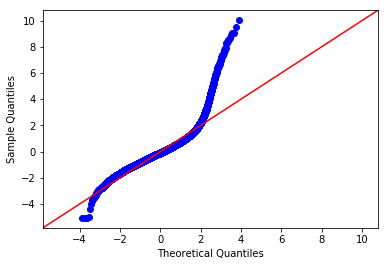

In [35]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

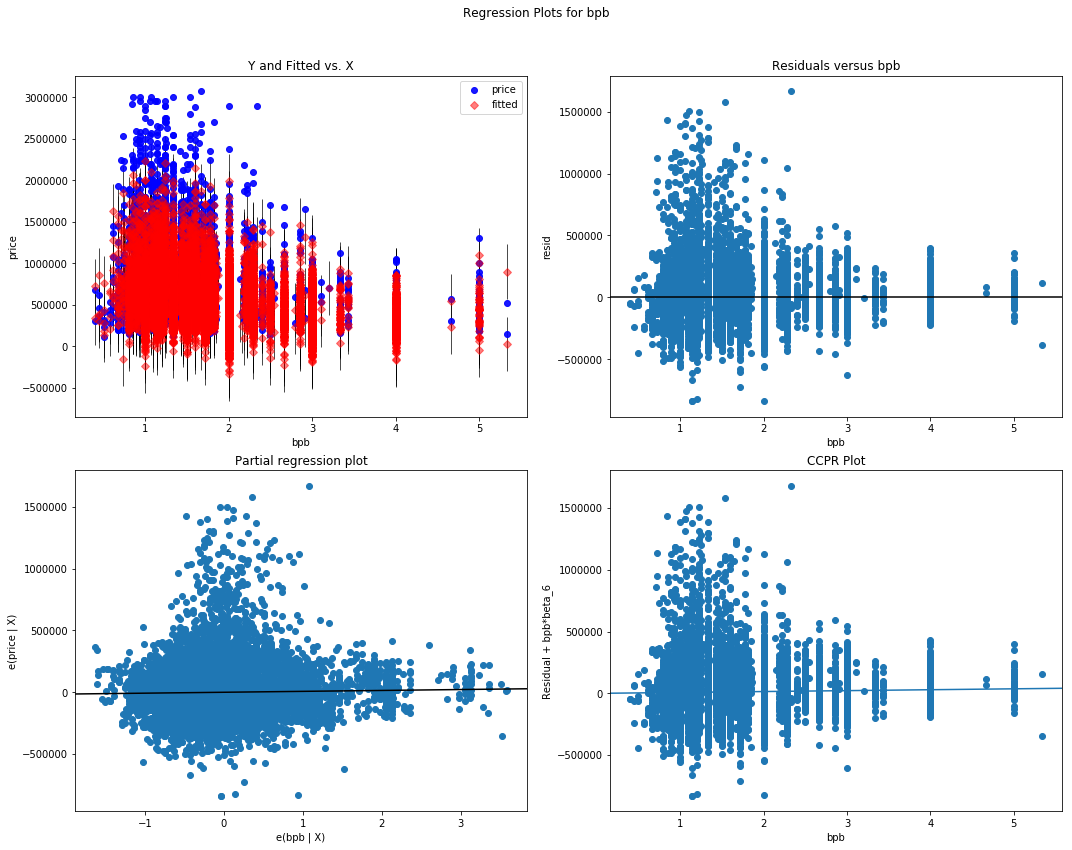

In [36]:
fig = plt.figure(figsize=(15,12))
fig = sm.graphics.plot_regress_exog(model, "bpb", fig=fig)
plt.show()

# This seems like a crazy idea, let's log the price!

So that QQ plot isn't quite where I want it to be.

In [37]:
non_normal = ['price']
for feat in non_normal:
    data[feat] = data[feat].map(lambda x: np.log(x))

In [38]:
# This raises the R-squared by 0.36, which nice,
# but you can see the waterfront's P>|t| is now 0.185

outcome = 'price'
x_cols = ['waterfront', 'view', 'condition', 'grade', 'price_per_sqft', 'bpb']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                 1.165e+04
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        09:42:02   Log-Likelihood:                -319.01
No. Observations:               21269   AIC:                             652.0
Df Residuals:                   21262   BIC:                             707.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.2842      0.019    553.844      0.000      10.248      10.321
waterfront         0.0367      0.024      1.514      0.130      -0.011       0.084
view               0.0191      0.003      7.500      0.000       0.014       0.024
condition          0.0227      0.003      8.421      0.000       0.017       0.028
grade              0.2780      0.002    164.165      0.000       0.275       0.281
price_per_sqft     0.0019   1.25e-05    149.884      0.000       0.002       0.002
bpb               -0.0206      0.003     -7.188      0.000      -0.026      -0.015
==============================================================================
Omnibus:                       61.115   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.538
Skew:                           0.067   Prob(JB):                     1.77e-16
Kurtosis:                       3.253   Cond. No.                     4.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
#removing waterfront does not impact the R-squared
# and the P values stays at 0
outcome = 'price'
x_cols = ['view', 'condition', 'grade', 'price_per_sqft', 'bpb']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                 1.397e+04
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        09:42:02   Log-Likelihood:                -320.16
No. Observations:               21269   AIC:                             652.3
Df Residuals:                   21263   BIC:                             700.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.2848      0.019    553.992      0.000      10.248      10.321
view               0.0204      0.002      8.474      0.000       0.016       0.025
condition          0.0226      0.003      8.390      0.000       0.017       0.028
grade              0.2779      0.002    164.215      0.000       0.275       0.281
price_per_sqft     0.0019   1.25e-05    150.387      0.000       0.002       0.002
bpb               -0.0207      0.003     -7.208      0.000      -0.026      -0.015
==============================================================================
Omnibus:                       62.943   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.591
Skew:                           0.070   Prob(JB):                     6.35e-17
Kurtosis:                       3.254   Cond. No.                     3.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

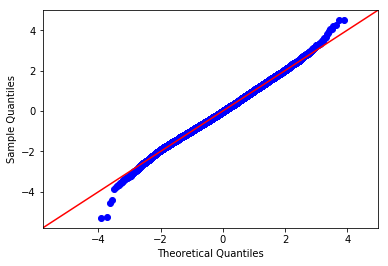

In [40]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

#that is a MUCH friendlier QQ plot

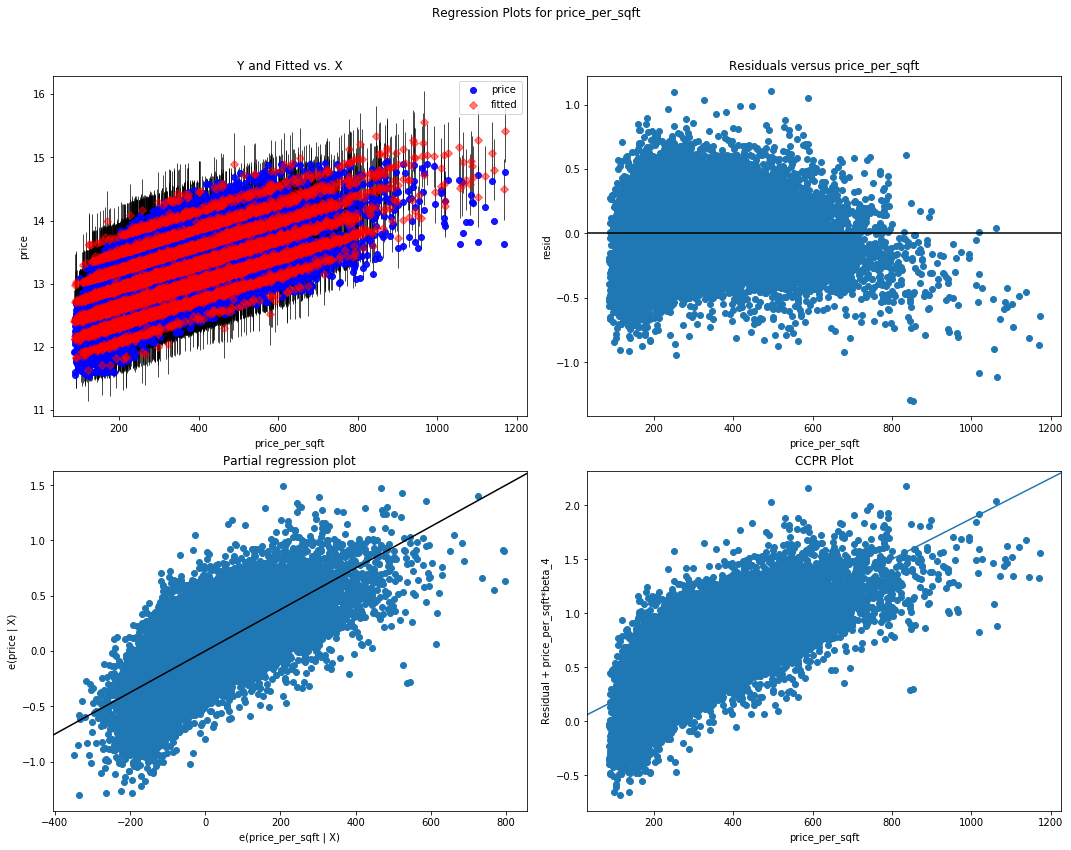

In [41]:
fig = plt.figure(figsize=(15,12))
fig = sm.graphics.plot_regress_exog(model, "price_per_sqft", fig=fig)
plt.show()

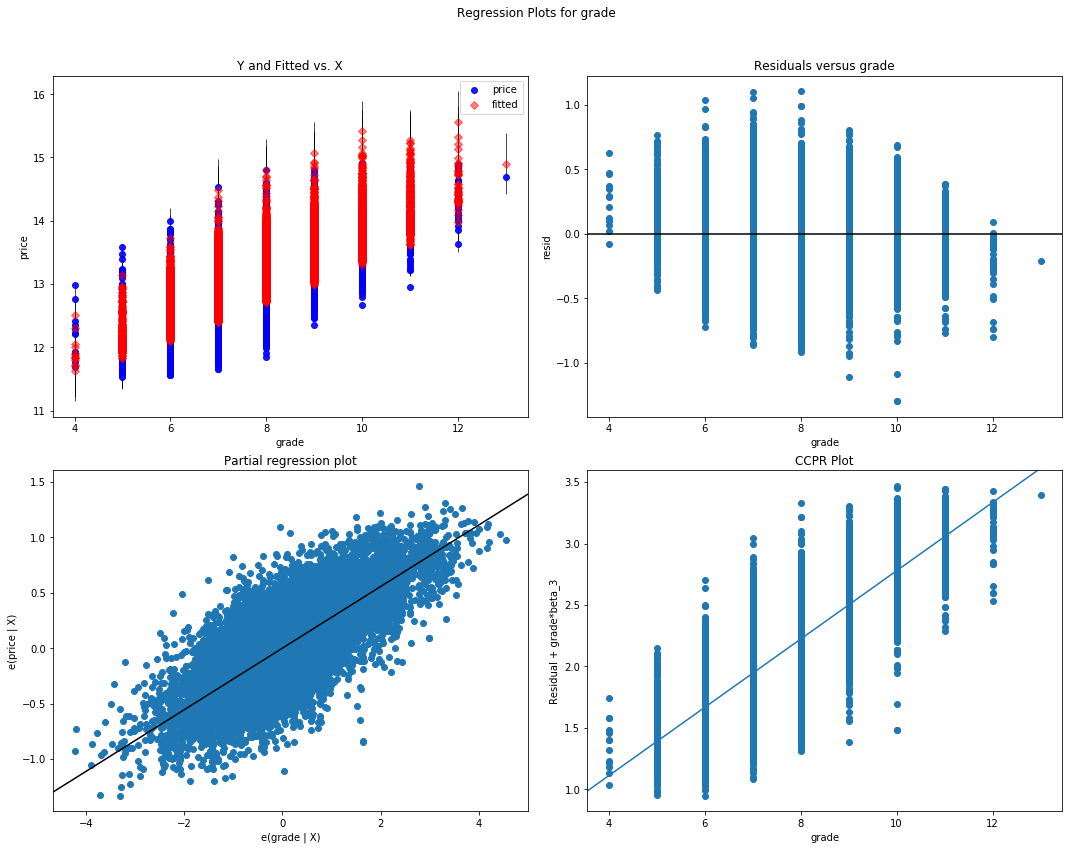

In [42]:
fig = plt.figure(figsize=(15,12))
fig = sm.graphics.plot_regress_exog(model, "grade", fig=fig)
plt.show()

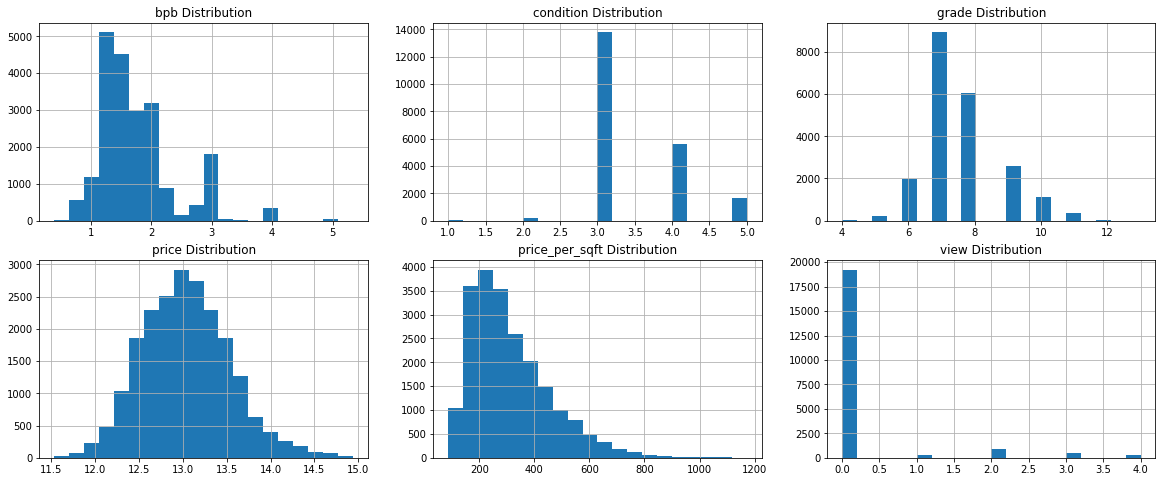

In [43]:
histograms(2, 3, ['bpb', 'condition', 'grade', 'price', 'price_per_sqft', 'view'], 20, (20,8))

# Log transform price per sqare foot 

In [44]:
non_normal = ['price_per_sqft']
for feat in non_normal:
    data[feat] = data[feat].map(lambda x: np.log(x))

In [45]:
#removing waterfront did not impact the R-squared, so I pulled it out
outcome = 'price'
x_cols = ['view', 'condition', 'grade', 'price_per_sqft', 'bpb']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                 1.536e+04
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        09:42:07   Log-Likelihood:                 459.19
No. Observations:               21269   AIC:                            -906.4
Df Residuals:                   21263   BIC:                            -858.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.3442      0.026    280.235      0.000       7.293       7.396
view               0.0321      0.002     13.942      0.000       0.028       0.037
condition          0.0226      0.003      8.692      0.000       0.017       0.028
grade              0.2748      0.002    168.344      0.000       0.272       0.278
price_per_sqft     0.6287      0.004    161.098      0.000       0.621       0.636
bpb               -0.0222      0.003     -8.037      0.000      -0.028      -0.017
==============================================================================
Omnibus:                      135.834   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.818
Skew:                           0.170   Prob(JB):                     3.57e-32
Kurtosis:                       3.220   Cond. No.                         168.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

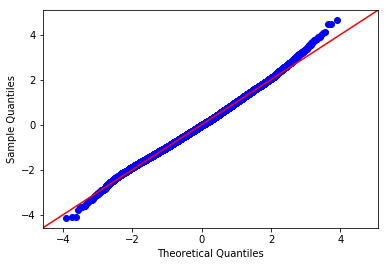

In [46]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

#that is a MUCH friendlier QQ plot

In [47]:
data.columns

Index(['date', 'price', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'price_per_sqft', 'bpb', 'comp15_sqft_living', 'comp15_sqft_lot',
       'since_reno'],
      dtype='object')

# Removing all columns I'm not using for the model

In [48]:
# this one is the snappening

data = data.drop(['date', 'sqft_lot', 'waterfront', 'sqft_above',
                  'sqft_basement', 'sqft_living15', 'sqft_lot15',
                  'comp15_sqft_living', 'comp15_sqft_lot', 'since_reno'], axis=1)

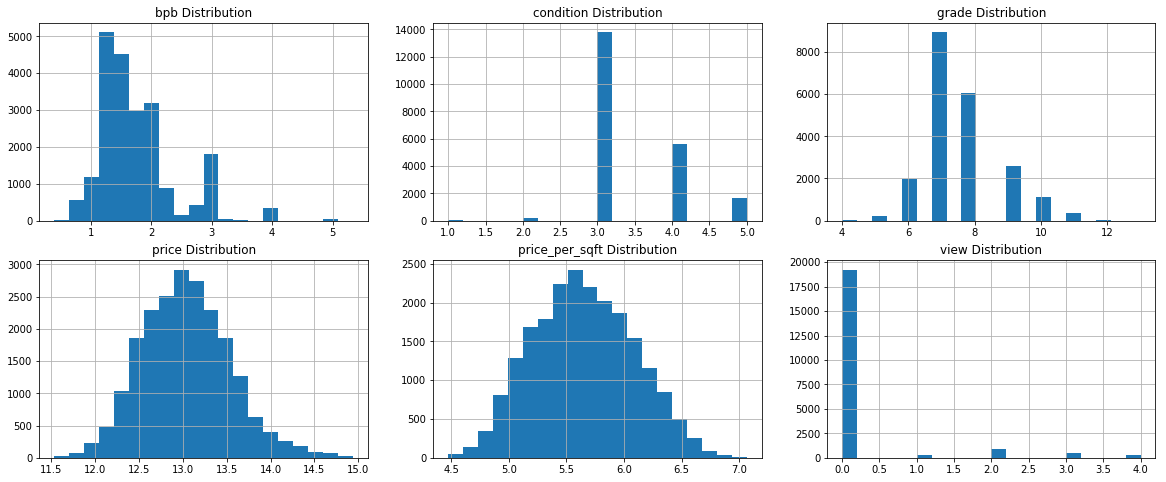

In [49]:
histograms(2, 3, ['bpb', 'condition', 'grade', 'price', 'price_per_sqft', 'view'], 20, (20,8))

In [50]:
non_normal = ['condition']
for feat in non_normal:
    data[feat] = data[feat].map(lambda x: np.log(x))

In [51]:
#removing waterfront does not impact the R-squared
outcome = 'price'
x_cols = ['view', 'condition', 'grade', 'price_per_sqft', 'bpb']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                 1.535e+04
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        09:42:08   Log-Likelihood:                 454.51
No. Observations:               21269   AIC:                            -897.0
Df Residuals:                   21263   BIC:                            -849.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.3277      0.027    272.930      0.000       7.275       7.380
view               0.0322      0.002     13.986      0.000       0.028       0.037
condition          0.0757      0.009      8.133      0.000       0.057       0.094
grade              0.2745      0.002    168.405      0.000       0.271       0.278
price_per_sqft     0.6294      0.004    161.469      0.000       0.622       0.637
bpb               -0.0221      0.003     -7.993      0.000      -0.028      -0.017
==============================================================================
Omnibus:                      135.720   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.722
Skew:                           0.169   Prob(JB):                     3.75e-32
Kurtosis:                       3.220   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Stepwise Selection

In [52]:
model_features = pd.DataFrame(data, columns = ['view', 'condition', 'grade', 'price_per_sqft', 'bpb'])

In [53]:
view = model_features['view']
condition = model_features['condition']
grade = model_features['grade']
price_per_sqft = model_features['price_per_sqft']
bpb = model_features['bpb']

In [54]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [55]:
X = model_features
y = pd.DataFrame(data, columns= ["price"])


In [56]:
result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)


Add  grade                          with p-value 0.0
Add  price_per_sqft                 with p-value 0.0
Add  view                           with p-value 2.85355e-46
Add  condition                      with p-value 5.66391e-14
Add  bpb                            with p-value 1.37962e-15
resulting features:
['grade', 'price_per_sqft', 'view', 'condition', 'bpb']


# Build the final model again in Statsmodels

In [57]:
X_fin = X[['view', 'condition', 'grade', 'price_per_sqft', 'bpb']]
X_int = sm.add_constant(X_fin)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                 1.535e+04
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        09:42:08   Log-Likelihood:                 454.51
No. Observations:               21269   AIC:                            -897.0
Df Residuals:                   21263   BIC:                            -849.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.3277      0.027    272.930      0.000       7.275       7.380
view               0.0322      0.002     13.986      0.000       0.028       0.037
condition          0.0757      0.009      8.133      0.000       0.057       0.094
grade              0.2745      0.002    168.405      0.000       0.271       0.278
price_per_sqft     0.6294      0.004    161.469      0.000       0.622       0.637
bpb               -0.0221      0.003     -7.993      0.000      -0.028      -0.017
==============================================================================
Omnibus:                      135.720   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.722
Skew:                           0.169   Prob(JB):                     3.75e-32
Kurtosis:                       3.220   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Use Feature ranking with recursive feature elimination

In [58]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 3)
selector = selector.fit(X, y)

In [59]:
selector.support_ 

array([False,  True,  True,  True, False])

In [60]:
selected_columns = X.columns[selector.support_ ]
linreg.fit(X[selected_columns],y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [61]:
yhat = linreg.predict(X[selected_columns])

In [62]:
SS_Residual = np.sum((y-yhat)**2)
SS_Total = np.sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X[selected_columns].shape[1]-1)


In [63]:
r_squared

price    0.780401
dtype: float64

In [64]:
adjusted_r_squared

price    0.78037
dtype: float64

# Let's Train Test Some Data!

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [67]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

15951 5318 15951 5318


In [68]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [69]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [70]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [71]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [72]:
from sklearn.metrics import mean_squared_error

In [73]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)


Train Mean Squarred Error: 0.05637614991617775
Test Mean Squarred Error: 0.0552860239387979


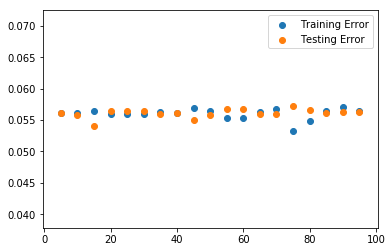

In [74]:
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()


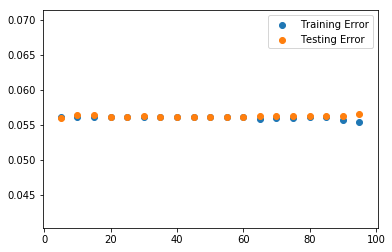

In [75]:
random.seed(8)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()